This notebook simulates accelerometer data, then feeds it to a model that predicts our position.

Measurement model: relates measurements to state at a given time. Model is $\text{Pr}(\mathbf{x}_t|\mathbf{w}_t)$.

Temporal model: describes relationship between adjacent states. Make the Markov assumption such that $\text{Pr}(\mathbf{w}_t | \mathbf{w}_{t-1})$


For inference we apply Bayes' rule
$$
    \text{Pr}(\mathbf{w}_1|\mathbf{x}_{1...t}) = \frac{\text{Pr}(\mathbf{x}_t | \mathbf{w}_t) \cdot \text{Pr}(\mathbf{w}_t | \mathbf{x}_{1...t-1})}{\text{Pr}(\mathbf{x}_{1...t})}
$$

Where the first term in the numerator is given by our generative model and the second term is computed using the Chapman-Kolmogorov relation, which exploits the Markov assumption and our inference for the previous time-step:
$$
    \text{Pr}(\mathbf{w}_t|\mathbf{x}_{1...t-1}) = \int \text{Pr}(\mathbf{w}_t|\mathbf{w}_{t-1}) \cdot \text{Pr}(\mathbf{w}_{t-1}|\mathbf{x}_{1...t-1}) \cdot d\textbf{w}_{t-1}
$$

Consequently we can see that inference consists of two steps:
1. Compute the current prior on the world state using the Chapman-Kolmogorov relation.
2. Compute the current posterior using Bayes' rule.


The parameters in our model parameterise the relationship between adjacent world states and the world state and observed data. In our case the world state variable is a vector containing three elements: displacement, velocity, and acceleration. Because we don't know the 'true' position of the razor, we must treat it as a hidden variable (i.e. a variable that has a realized value, but one that we are not sure of). Fitting the model therefore consists of alternating between estimating the hidden variables and the parameters for the model.


##### Temporal model
The temporal model relates adjacent world states. It is quite simple: a linear function of the previous world state, plus some noise, and a mean change:

$$
    \mathbf{w}_t = \mathbf{\mu}_{p} + \mathbf{\Psi}\mathbf{w}_{t-1} + \mathbf{\epsilon}_{p}
$$

The linear transformation matrix is known as the transition matrix - it relates the mean state at time $t$ to the mean state at time $t-1$. Since we assume the noise is Gaussian, we can express the above relationship as:

$$
    \text{Pr}(\mathbf{w}_t | \mathbf{w}_{t-1}) = \text{Norm}_{\mathbf{w}_t}[\mathbf{\mu}_p + \mathbf{\Psi}\mathbf{w}_{t-1}, \mathbf{\Sigma}_p]
$$

Note that the covariance matrix doesn't necessarily have to be spherical or diagonal - we can express correlations between various forms of noise.


##### Measurement model
The measurement model relates the measurements to the world state. It also takes the form of an affine function.

$$
    \mathbf{x}_t = \mathbf{\mu}_{m} + \mathbf{\Phi}\mathbf{w}_{t} + \mathbf{\epsilon}_{m}
$$

Again, we can express this as a probability distribution:

$$
    \text{Pr}(\mathbf{x}_t | \mathbf{w}_{t}) = \text{Norm}_{\mathbf{x}_t}[\mathbf{\mu}_m + \mathbf{\Phi}\mathbf{w}_{t}, \mathbf{\Sigma}_m]
$$

By choosing both the prior (i.e. the temporal model) and the likelihood (the measurement model) to be normal, we produce a conjugate relation that means the posterior (i.e. the distribution over the world state, given the measurements) is also normal.


##### Inference
Inference consists of recursively computing the measurement distribution and the temporal distribution. In the prediction step we evaluate the Chapman-Kolmogorov equation to find the prior over the world state for the current time-step:

$$
    \text{Pr}(\mathbf{w}_t | \mathbf{x}_{1...t-1}) = \int \text{Norm}_{\mathbf{w}_t}[\mathbf{\mu}_p + \mathbf{\Psi}\mathbf{w}_{t-1}, \mathbf{\Sigma}_p] \cdot \text{Norm}_{\mathbf{w}_{t-1}}[\mathbf{\mu}_{t-1}, \mathbf{\Sigma}_{t-1}] \cdot d\mathbf{w}_{t-1}
$$

$$
    = \text{Norm}_{\mathbf{w}_t}[\mathbf{\mu}_p + \mathbf{\Psi}\mathbf{\mu_{t-1}}, \Sigma_p + \mathbf{\Psi}\Sigma_{t-1}\Psi^T]
$$

$$
    = \text{Norm}_{\mathbf{w}_t}[\mathbf{\mu}_{+}, \mathbf{\Sigma}_{+}]
$$

We then apply Bayes' rule for the posterior over the world state given the measurements. For notational convenience, we define the Kalman gain $\mathbf{K}$ as:

$$
    \mathbf{K} = \mathbf{\Sigma}_{+}\mathbf{\Phi}^T (\mathbf{\Sigma}_m + \mathbf{\Phi}\mathbf{\Sigma}_{+}\mathbf{\Phi}^T)^{-1}
$$

Where $\mathbf{\Phi}$ is the linear transformation matrix from the measurement model. The posterior over the world state given the measurements is then:

$$
    \text{Pr}(\mathbf{w}_t|\mathbf{x}_{1...t}) = \text{Norm}_{\mathbf{w}_t}[\mathbf{\mu}_t, \mathbf{\Sigma}_t]
$$

where:

$$
\mathbf{\mu}_t = \mathbf{\mu}_{+} + \mathbf{K}(\mathbf{x}_t - \mathbf{\mu}_m - \mathbf{\Phi}\mathbf{\mu}_{+})
$$

$$
    \mathbf{\Sigma}_t = (\mathbf{I} - \mathbf{K}\mathbf{\Phi})\mathbf{\Sigma}_{+}
$$

Both of these expressions can be understood as a weighting of the prior and the measured world states. The term in brackets for the mean is called the *innovation* - it corresponds to the difference between the predicted measurements and the actual measurements.

In [ ]:
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline

# 1. Generate simulated path data

In [ ]:
plt.style.use('ggplot')

PATH_RADIUS = 5
N_POINTS    = 50
TH_START    = -np.pi/2
TH_STOP     = np.pi
JITTER_SD   = 0.2
true_world_states = np.array([[PATH_RADIUS*np.cos(th), PATH_RADIUS*np.sin(th)]
                               for th in np.linspace(TH_START, TH_STOP, N_POINTS)])
jitter      = JITTER_SD*np.random.rand(N_POINTS, 2)
true_world_states += jitter

# 2. Associate some noisy absolute position measurements with this data

In [ ]:
NOISE_SD = 2
measurement_noise = np.random.rand(N_POINTS, 2) - 0.5
measurements = true_world_states + NOISE_SD*measurement_noise

# 3. Apply the Kalman filter to the measurements

In [ ]:
# BROWNIAN MOTION MODEL
#---------------------

# 1. Generate a smooth path.
# 2. Add Gaussian noise to the path to generate a set of 'measurements'.
# 3. Define \mu_{0} as the initial world state (i.e. calibrate).
# 4. Define \Sigma_{0} as a large multiple of the identity matrix.

# Prediction step
# 4. Estimate the prediction step mean, \mu_{+} => Mean world state, given previous world state
#    \mu_{+} = \mu_{t-1} for the Brownian motion model
# 5. Estimate the prediction step covariance, \Sigma_{+} => World state covariance, given previous world state
#    \Sigma_{+} = \Sigma_{p} + \Sigma_{t-1}


# State update step
# 6. Compute the Kalman gain, here:
#    K = \Sigma_{+} (\Sigma_m + \Sigma_{+})^{-1}
# 7. Update the current world state mean:
#    mu_{t} = \mu_{+} + K(x_t - \mu_{+})
# 8. Update the current world state variance:
#    \Sigma_{t} = (I - K) \Sigma_{+}

In [ ]:
mu    = np.zeros([N_POINTS, 2]) # Mean positional estimate for each time-step
Sigma = np.zeros([N_POINTS, 2, 2]) # Mean variance estimate for each time-step

# Calibrate the initial position
mu[0, :]       = true_world_states[0, :]
Sigma[0, :, :] = 0.01*np.eye(2) # Small uncertainty in initial position

# Estimate the prediction and measurement parameters

# Prediction parameters
# In this model, we assume that the most likely position given the last is the last (i.e. zero mean change)
# For the variance of the model, we make an educated guess of 0.3
# This value can be thought of as a circle centered on the previous position that constrains the next most likely position.
Sigma_p = 0.6*np.eye(2) # We assume that movements in either direction are not correlated

# Identity mapping from the measurement to the world state, with  an estimated error of 2 (e.g. read from datasheet)
Sigma_m = 2*np.eye(2)

for t in range(1, N_POINTS):
    # > Prior prediction <
    # Predict the new mean position based on the last step alone
    mu_plus    = mu[t-1, :]
    
    # Predict the new variance based on the last step
    Sigma_plus = Sigma_p + Sigma[t-1, :, :]
    
    # > Measurement Incorporation <
    K              = np.matmul(Sigma_plus, np.linalg.inv(Sigma_m + Sigma_plus)) # Kalman gain
    mu[t, :]       = mu_plus + np.matmul(K, measurements[t, :] - mu_plus)
    Sigma[t, :, :] = np.matmul(np.eye(2) - K, Sigma_plus)

In [ ]:
# Display the results

f, axs = plt.subplots(1, 2, figsize = (15, 8))
axs[0].plot(true_world_states[:, 0], true_world_states[:, 1], 'go-', linewidth=0.5, label = 'True path')
axs[0].plot(measurements[:, 0], measurements[:, 1], 'b.-', linewidth=0.5, label = 'Measured path')
axs[1].plot(true_world_states[:, 0], true_world_states[:, 1], 'go-', linewidth=0.5, label = 'True path')
axs[1].plot(mu[:, 0], mu[:, 1], 'r.-', linewidth=0.5, label = 'Estimated path')

axs[0].set_title('Naive position estimate using measurements')
axs[1].set_title('Kalman-filtered position estimate')

plt.title('Enhanced position estimate using Kalman filter')
for ax in axs:
    ax.set_xlabel('x-position')
    ax.set_ylabel('y-position')
    ax.legend(fontsize = 14, loc = 3)

We can see that the Kalman-filtered path estimate is markedly smoother, directionally consistent, and geometrically accurate. The remarkable thing about this model is that we make no assumptions about the nature of the underlying movement - even were the path being followed were sinusoidal (per se), the filter would perform similarly well. If we have knowledge of likely movements (e.g. approximately unidirectional razor blade movements) then we can vastly improve the accuracy of our estimates.

To incorporate this kind of understanding into our model, we make a dynamic estimate of the change in world state.

In [ ]:
mu    = np.zeros([N_POINTS, 4])
Sigma = np.zeros([N_POINTS, 4, 4])

# Calibrate initial position
mu[0, :2]      = true_world_states[0, :2]
mu[0, 2:]      = 0 # Initial velocity
Sigma[0, :, :] = 0.01*np.eye(4)

# Initialize prediction/measurement variance, mean change
Sigma_p = 0.5*np.eye(4)          # Make an educated initial guess
Sigma_p[-1, -1] = 0.001
Sigma_p[-2, -2] = 0.001
phi_p   = np.array([[1, 0, 1, 0], [0, 1, 0, 1], [0, 0, 1, 0], [0, 0, 0, 1]]) 
# ^ Account for velocities in predicted positions

Sigma_m = 2*np.eye(2)      # Assume the measurements are v. noisy
phi_m   = np.array([[1, 0, 0, 0], [0, 1, 0, 0]])  # Measurements only relate to first two dimensions of prediction

# Iterate, updating the mean direction change on each step
for t in range(1, N_POINTS):
    # Predict new position based on previous position
    mu_plus    = np.matmul(phi_p, mu[t-1, :])
    Sigma_plus = Sigma_p + np.matmul(np.matmul(phi_p, Sigma[t-1, :, :]), phi_p.T)
    
    # Incorporate measurements into position estimate
    K              = np.matmul(np.matmul(Sigma_plus, phi_m.T),
                               np.linalg.inv(Sigma_m + 
                                             np.matmul(
                                                np.matmul(phi_m, Sigma_plus),
                                                phi_m.T)
                                            )
                              )
    mu[t, :]       = mu_plus + np.matmul(K, (measurements[t, :] - mu_m - np.matmul(phi_m, mu_plus)))
    Sigma[t, :, :] = np.matmul((np.eye(4) - np.matmul(K, phi_m)), Sigma_plus)

In [ ]:
# Display the results

f, axs = plt.subplots(1, 2, figsize = (15, 8))
axs[0].plot(true_world_states[:, 0], true_world_states[:, 1], 'go-', linewidth=0.5, label = 'True path')
axs[0].plot(measurements[:, 0], measurements[:, 1], 'b.-', linewidth=0.5, label = 'Measured path')
axs[1].plot(true_world_states[:, 0], true_world_states[:, 1], 'go-', linewidth=0.5, label = 'True path')
axs[1].plot(mu[:, 0], mu[:, 1], 'r.-', linewidth=0.5, label = 'Estimated path')

axs[0].set_title('Naive position estimate using measurements')
axs[1].set_title('Kalman-filtered position estimate')

plt.title('Enhanced position estimate using Kalman filter')
for ax in axs:
    ax.set_xlabel('x-position')
    ax.set_ylabel('y-position')
    ax.legend(fontsize = 14, loc = 3)

In [3]:
from IPython.display import HTML
import numpy as np
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline

In [170]:
HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
The raw code for this IPython notebook is by default hidden for easier reading.
To toggle on/off the raw code, click <a href="javascript:code_toggle()">here</a>.''')

# 3D Simulation

This model makes an estimate of a world-state (i.e. a position, a velocity, and so on) based on a set of previous measurements. At each time-step, we incorporate a new set of measurements and consider where we have been previously. 

Taking the world-state to be our position in space for now, the model functions by considering:
    - A predicted movement.
    - A measured movement.

We can (1) and (2) to favour predicted or measured movements. If our measurements are noisy and we know what type of motion is taking place, then we would prefer to rely on our predictions. By contrast, if our measurements are accurate then there is no need to rely on our predictions.

In the razor model, we do not estimate position alone at each time-step - we also make estimates of velocity and acceleration. By seeking the most likely values for these derivative quantities, we can estimate our position more accurately.


Algorithmically, the program does the following:

    1. Define a relationship between adjacent world-states. For example, we would estimate the next position as being equal to the current one plus the movement in that time. For example,
$$
    \text{Current world-state velocity} = \text{Previous world state velocity} + \text{Previous world state acceleration}\cdot \Delta t
$$
    2. Define a relationship between our measurements and world-state: if we are measuring linear acceleration and the sensor is unbiased, then we would use:
$$
    \text{Measured acceleration} = \text{World-state acceleration} + \text{Noise}
$$
    3. Define an initial world state (i.e. calibrate).
    4. After each time-step:
        1. Predict a set of current world-states based on the previous world state alone (use the relationship in Step 1).
        2. Determine what world-states would corroborate our measurements (use the relationship in Step 2).
        3. Return the world-state that is most likely based on both our prediction and measurements.
   
You may be wondering whether we can incorporate later measurements to improve our positional estimate. We can - and will - however for the purposes of this demo I wanted to keep it simple.

### Equations

Relationship between adjacent world states:
$$
    w_t = \Phi_p w_{t-1} + \text{Error}
$$
Relationship between world state and measured state:
$$
    x_t = \Phi_m w_t + \text{Noise}
$$

Both $\Phi_p$ and $\Phi_m$'s meanings are described below - they are simply matrices that we use to sum the appropriate velocities, accelerations, and displacements as per the physical laws.

By assuming that both the noise and the error are normally distributed r.v.s, we can derive equations that allow us to perform the weighting of predictions and measurements as described above. Assuming normality means that:
    1. We can quickly compute an updated world state (normal distributions are mathematically convenient).
    2. We can express uncertainty in our predicted world state and our measurements.
    
The update equations follow and are for my own reference - they are not important to understanding how the model works.

State prediction:
$$
    \mu_{+} = \mu_{p} + \Phi_{p}\mu_{t-1}
$$
Covariance prediction:
$$
    \Sigma_{+} = \Sigma_{p} + \Phi_{p}\Sigma_{t-1}\Phi_{p}^T
$$
Kalman gain:
$$
    K = \Sigma_{+}\Phi_m^T (\Sigma_m + \Phi_m \Sigma_{+} \Phi_m^T)^{-1}
$$
State update:
$$
    \mu_{t} = \mu_{+} + K(x_{t} - \mu_m - \Phi_m \mu_{+})
$$
Covariance update:
$$
    \Sigma_{t} = (I - K\Phi_m)\Sigma_{+}
$$

For the meaning of each variable please see the code spec. below. If you are interested in how these expressions are derived (they are not obvious) I can elaborate on them further.

In [4]:
"""
Data structures:

    dt      : (Scalar float)  Sensor sampling period.
    N       : (Scalar  int )  Number of datapoints gathered.
    
    mu      : (Matrix float)  Matrix containing most probable world states at each instant.
                              Rows correspond to [displacement_xyz, velocity_xyz, acceleration_xyz] at time R*dt.
                              [N rows x 9 columns]
    Sigma   : (Tensor float)  Stack of world state covariance matrices (i.e. uncertainty measures).
                              Dimensions 2 and 3 correspond to Var(w, w), first dimension is time index.
                              [N x 9 x 9]
                              
    Phi_p   : (Matrix float)  Describes relationship between adjacent world states.
                              [9 x 9]
    Sigma_p : (Matrix float)  Prediction covariance matrix - quantifies uncertainty in each dimension (displ., vel, acc.)
                              of the world state prediction based on the predeceeding world state.
                              [9 x 9]
                              
    Phi_m   : (Matrix float)  Describes relationship between world state and measurements.
                              [3 x 9]
    Sigma_m : (Matrix float)  Describes measurement noise (i.e. noise in each dimension + their correlations).
                              [3 x 3]
                              
    mu_x    : (Vector float)  Mean predicted world state, based on the last world-state alone.
                              [9]
    Sigma_x : (Matrix float)  Prediction covariance matrix (represents uncertainty in each prediction dimension)
                              [9 x 9]
                              
    K       : (Matrix float)  Kalman gain - weights measurements relative to predictions.
                              [9 x 9]
                              
    X       : (Matrix float)  Measurements - each row corresponds to one sample, x_t = [ax, ay, az].
                              [N x 3]
    W       : (Matrix float)  True simulated world states (i.e. where the blade actually is, how fast it is moving).
                              Rows are w_t.
                              [N x 9]
                              
    Variables that get updated are mu_x, Sigma_x, mu, Sigma, and K.

"""

'\nData structures:\n\n    dt      : (Scalar float)  Sensor sampling period.\n    N       : (Scalar  int )  Number of datapoints gathered.\n    \n    mu      : (Matrix float)  Matrix containing most probable world states at each instant.\n                              Rows correspond to [displacement_xyz, velocity_xyz, acceleration_xyz] at time R*dt.\n                              [N rows x 9 columns]\n    Sigma   : (Tensor float)  Stack of world state covariance matrices (i.e. uncertainty measures).\n                              Dimensions 2 and 3 correspond to Var(w, w), first dimension is time index.\n                              [N x 9 x 9]\n                              \n    Phi_p   : (Matrix float)  Describes relationship between adjacent world states.\n                              [9 x 9]\n    Sigma_p : (Matrix float)  Prediction covariance matrix - quantifies uncertainty in each dimension (displ., vel, acc.)\n                              of the world state prediction based

### 1. Simulate a path.

In [199]:
N   = 100  # Number of datapoints
dt  = 0.1 # Sampling period
W   = np.zeros([N, 9])

# Generate a path
t = np.linspace(0, 1.5*np.pi, N) # Path parameter

a = 100*np.array([np.cos(t), np.sin(t), np.sin(t)]).T # Acceleration vectors
v = np.zeros([N, 3])
s = np.zeros([N, 3])

for i in range(1, N):
    v[i, :] = v[i-1, :] + a[i, :]*dt
    s[i, :] = s[i-1, :] + (v[i, :] + v[i-1, :])*dt*0.5
    
W = np.concatenate([s, v, a], axis = 1) # Matrix of world states

### 2. Simulate an associated set of accelerometer measurements for this path.

In [200]:
NOISE_SD = 0.1*(np.max(a) - np.min(a))
X        = W[:, -3:] + np.random.normal(loc = 0, scale = NOISE_SD,
                                        size = [N, 3]) # Assume noise in each direction is uncorrelated

# Use the measurements to directly ('naively') estimate displacement
nv = np.zeros([N, 3])
ns = np.zeros([N, 3])

for i in range(1, N):
    nv[i, :] = nv[i-1, :] + X[i, :]*dt
    ns[i, :] = ns[i-1, :] + (nv[i, :] + nv[i-1, :])*dt*0.5

### 3. Configure the model parameters.

In [240]:
# Relationship between adjacent world states
Phi_p           = np.eye(9)
dt_ix           = (range(0, 6), range(3, 9))
dt_sq_ix        = (range(0, 3), range(6, 9))
Phi_p[dt_ix]    = dt
Phi_p[dt_sq_ix] = 0.5 * dt**2

np.set_printoptions(precision = 4)
print(Phi_p)

[[ 1.     0.     0.     0.1    0.     0.     0.005  0.     0.   ]
 [ 0.     1.     0.     0.     0.1    0.     0.     0.005  0.   ]
 [ 0.     0.     1.     0.     0.     0.1    0.     0.     0.005]
 [ 0.     0.     0.     1.     0.     0.     0.1    0.     0.   ]
 [ 0.     0.     0.     0.     1.     0.     0.     0.1    0.   ]
 [ 0.     0.     0.     0.     0.     1.     0.     0.     0.1  ]
 [ 0.     0.     0.     0.     0.     0.     1.     0.     0.   ]
 [ 0.     0.     0.     0.     0.     0.     0.     1.     0.   ]
 [ 0.     0.     0.     0.     0.     0.     0.     0.     1.   ]]


In [270]:
# Estimate sq. deviation from predicted position - the measurements can be used to estimate this
true_sd = np.std(W[1:, :] - np.matmul(W[:-1, :], Phi_p.T), axis = 0)
#Sigma_p = np.diag(true_sd**2)
Sigma_p = 400*np.eye(9) # Why the heck would this improve performance?
np.set_printoptions(suppress=True, precision = 4)
print(Sigma_p)

[[ 400.    0.    0.    0.    0.    0.    0.    0.    0.]
 [   0.  400.    0.    0.    0.    0.    0.    0.    0.]
 [   0.    0.  400.    0.    0.    0.    0.    0.    0.]
 [   0.    0.    0.  400.    0.    0.    0.    0.    0.]
 [   0.    0.    0.    0.  400.    0.    0.    0.    0.]
 [   0.    0.    0.    0.    0.  400.    0.    0.    0.]
 [   0.    0.    0.    0.    0.    0.  400.    0.    0.]
 [   0.    0.    0.    0.    0.    0.    0.  400.    0.]
 [   0.    0.    0.    0.    0.    0.    0.    0.  400.]]


In [271]:
# Relationship between measurements and true world state
Phi_m           = np.zeros([3, 9])
Phi_m[0:3, 6:9] = np.eye(3) # Only retains the acceleration values (i.e. what we're measuring)
print(Phi_m)

[[ 0.  0.  0.  0.  0.  0.  1.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  1.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  1.]]


In [272]:
# Roughly estimate sensor noise
true_noise = np.std(X - np.matmul(W, Phi_m.T), axis = 0)
Sigma_m    = true_noise**2 * np.eye(3)
print(Sigma_m)

[[ 331.4251    0.        0.    ]
 [   0.      397.6811    0.    ]
 [   0.        0.      406.1049]]


In [273]:
# Predicted world state + variances based on previous w.s. alone
mu_plus    = np.zeros([9, 1])
Sigma_plus = np.zeros([9, 9])

In [274]:
# World state estimates at each time step
mu    = np.zeros([N, 9])
Sigma = np.zeros([N, 9, 9])

# Calibrate the first value
mu[0, :]  = W[0, :]

### 4. Run the estimates.

In [275]:
def kalman_gain(Sigma_plus, Phi_m, Sigma_m):
    t1 = np.matmul(Sigma_plus, Phi_m.T)
    t2 = np.linalg.inv(Sigma_m + np.matmul(np.matmul(Phi_m, Sigma_plus), Phi_m.T))
    K  = np.matmul(t1, t2)
    return K

I = np.eye(9)

for t in range(1, N):
    # 1. Predict world state based on previous world state alone (prior).
    mu_plus    = np.matmul(Phi_p, mu[t-1, :])
    Sigma_plus = Sigma_p + np.matmul(np.matmul(Phi_p, Sigma[t-1, :, :]), Phi_p.T)
    
    # 2. Compute Kalman gain (measurement weighting).
    K = kalman_gain(Sigma_plus, Phi_m, Sigma_m)
    
    # 3. Combine measurements and prediction to form a final estimate for the current world state.
    mu[t, :]       = mu_plus + np.matmul(K, X[t, :] - np.matmul(Phi_m, mu_plus))
    Sigma[t, :, :] = np.matmul(I - np.matmul(K, Phi_m), Sigma_plus)

### 5. Visualize the results.

The improvement is most obvious in acceleration space.

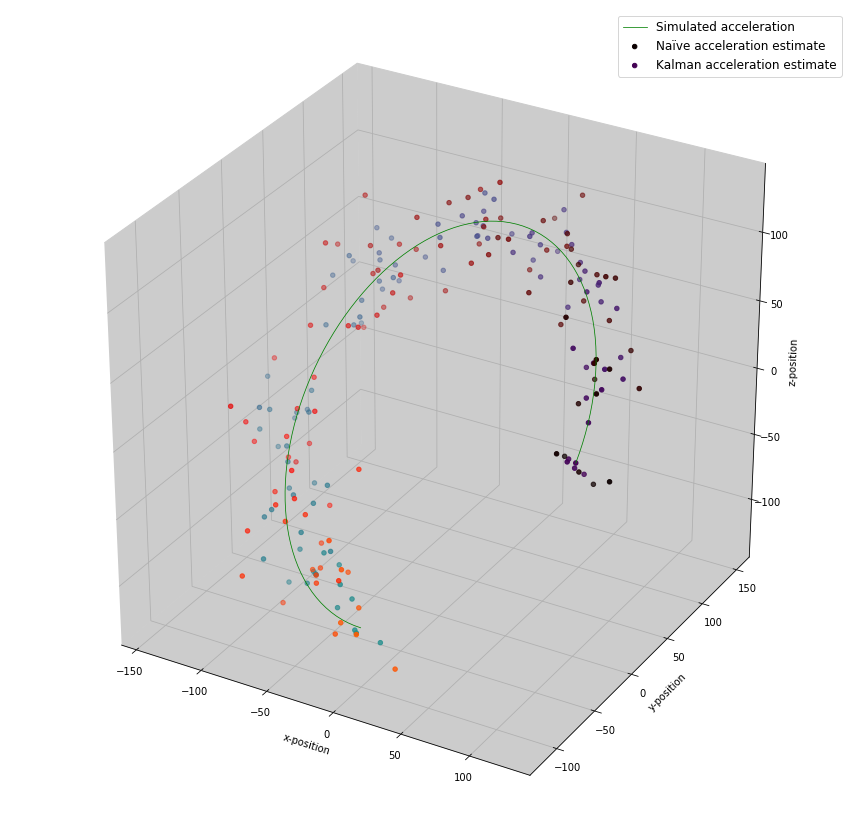

In [276]:
# @hidden_cell
# Display the path
fig = plt.figure(figsize = (15, 15))
ax  = fig.add_subplot(111, projection='3d')

ax.plot(a[:, 0], a[:, 1], a[:, 2],
           zdir='z',
           c = 'green', linewidth=0.75, label = 'Simulated acceleration')
ax.scatter(X[:, 0], X[:, 1], X[:, 2],
           zdir='z', s=20, depthshade=True,
           c = plt.cm.hot(np.linspace(0, 0.5, N)),
           label = 'Naïve acceleration estimate')
ax.scatter(mu[:, 6], mu[:, 7], mu[:, 8],
           zdir='z', s=20, depthshade=True,
           c = plt.cm.viridis(np.linspace(0, 0.5, N)),
           label = 'Kalman acceleration estimate')
ax.set_xlabel('x-position')
ax.set_ylabel('y-position')
ax.set_zlabel('z-position')

ax.legend(fontsize = 12);

plt.gca().patch.set_facecolor('white')
ax.w_xaxis.set_pane_color((0.8, 0.8, 0.8, 1.0))
ax.w_yaxis.set_pane_color((0.8, 0.8, 0.8, 1.0))
ax.w_zaxis.set_pane_color((0.8, 0.8, 0.8, 1.0))

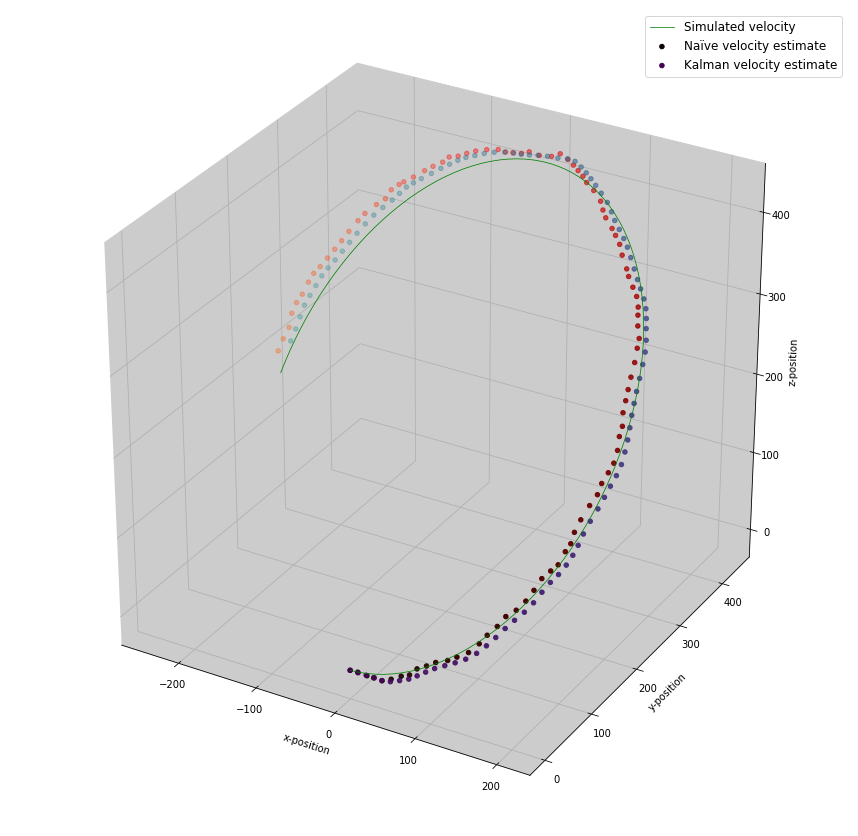

In [277]:
# Display the path
fig = plt.figure(figsize = (15, 15))
ax  = fig.add_subplot(111, projection='3d')

ax.plot(v[:, 0], v[:, 1], v[:, 2],
           zdir='z',
           c = 'green', linewidth=0.75, label = 'Simulated velocity')
ax.scatter(nv[:, 0], nv[:, 1], nv[:, 2],
           zdir='z', s=20, depthshade=True,
           c = plt.cm.hot(np.linspace(0, 0.5, N)),
           label = 'Naïve velocity estimate')
ax.scatter(mu[:, 3], mu[:, 4], mu[:, 5],
           zdir='z', s=20, depthshade=True,
           c = plt.cm.viridis(np.linspace(0, 0.5, N)),
           label = 'Kalman velocity estimate')
ax.set_xlabel('x-position')
ax.set_ylabel('y-position')
ax.set_zlabel('z-position')

ax.legend(fontsize = 12);

plt.gca().patch.set_facecolor('white')
ax.w_xaxis.set_pane_color((0.8, 0.8, 0.8, 1.0))
ax.w_yaxis.set_pane_color((0.8, 0.8, 0.8, 1.0))
ax.w_zaxis.set_pane_color((0.8, 0.8, 0.8, 1.0))

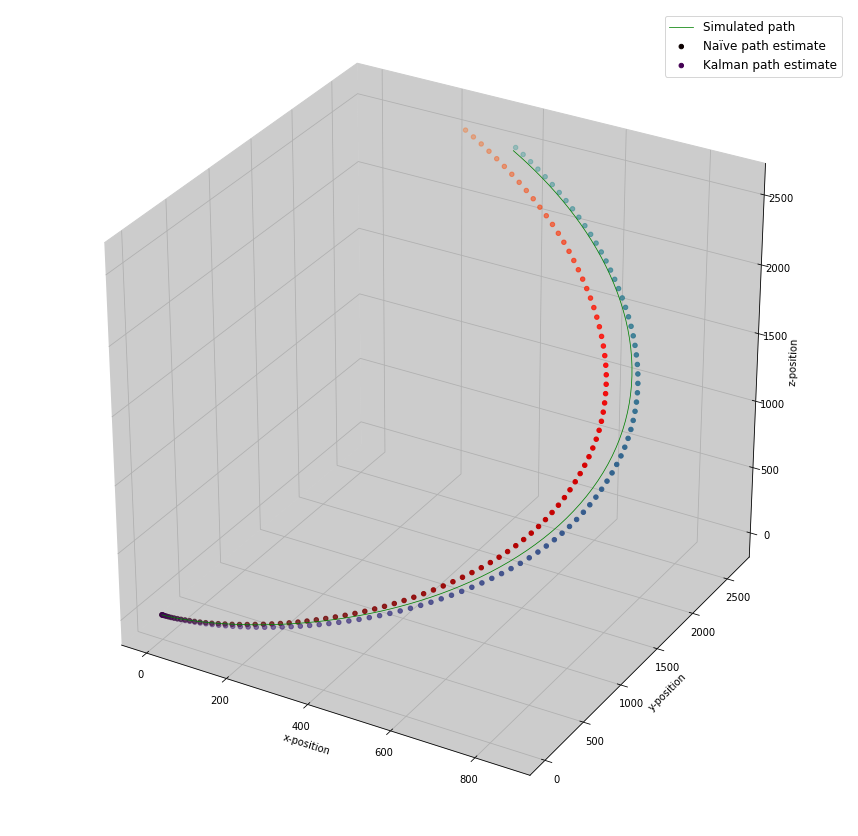

In [278]:
# Display the path
fig = plt.figure(figsize = (15, 15))
ax  = fig.add_subplot(111, projection='3d')

ax.plot(s[:, 0], s[:, 1], s[:, 2],
           zdir='z',
           c = 'green', linewidth=0.75, label = 'Simulated path')
ax.scatter(ns[:, 0], ns[:, 1], ns[:, 2],
           zdir='z', s=20, depthshade=True,
           c = plt.cm.hot(np.linspace(0, 0.5, N)),
           label = 'Naïve path estimate')
ax.scatter(mu[:, 0], mu[:, 1], mu[:, 2],
           zdir='z', s=20, depthshade=True,
           c = plt.cm.viridis(np.linspace(0, 0.5, N)),
           label = 'Kalman path estimate')
ax.set_xlabel('x-position')
ax.set_ylabel('y-position')
ax.set_zlabel('z-position')

ax.legend(fontsize = 12);

plt.gca().patch.set_facecolor('white')
ax.w_xaxis.set_pane_color((0.8, 0.8, 0.8, 1.0))
ax.w_yaxis.set_pane_color((0.8, 0.8, 0.8, 1.0))
ax.w_zaxis.set_pane_color((0.8, 0.8, 0.8, 1.0))

In [279]:
np.mean((ns - s)**2) # Naive RSS

1781.6796901998307

In [280]:
np.mean((mu[:, :3] - s)**2) # Kalman RSS

360.59549043797813

In [281]:
np.mean((nv - v)**2) # Naive RSS

160.19962853142709

In [282]:
np.mean((mu[:, 3:6] - v)**2) # Kalman RSS

118.85982984669768

In [283]:
np.mean((X - a)**2) # Naive RSS

384.26347097543714

In [284]:
np.mean((mu[:, 6:] - a)**2) # Kalman RSS

185.20523541915389

WHAT THE HECK IS WRONG WITH OUR PREDICTION ERROR ESTIMATE?